In [2]:
# preamble
import glob
import os
from PIL import Image
import cv2
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision
from utils import train, predict, score_fluoroscopy, score_time, score_xray, score_retries_cannulated_dhs, score_retries_hansson, \
                drill_dist_hansson, guidewire_dist, drill_dist_hansson
from skimage.io import imread_collection
import matplotlib.pyplot as plt
import pandas as pd
import os
from unittest import TestLoader
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm
plt.style.use('seaborn')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
# set up weights and biases (wandb.ai)

import wandb

wandb.init(project = "ort-project", entity = "ditteblom", reinit=True)

wandb: Currently logged in as: macaroni (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Create the dataset as a torch dataset.

In [4]:
class SimulationData(torch.utils.data.Dataset):
    def __init__(self, repair_type, split, transform = None, data_path = "Data", train_size = 0.8, test_size = 0.2, seed = 8):
        'Initializing data'
        self.data_path = data_path
        self.repair_type = repair_type + "/001_copenahgen_test_1"
        #self.type = type
        self.transform = transform

        img_files = glob.glob(self.data_path + '***/**/*.jpg', recursive=True)
        img_files = [ x for x in img_files if self.repair_type in x ]
        score_files = glob.glob(self.data_path + '***/**/*.txt', recursive=True)
        score_files = [ x for x in score_files if self.repair_type in x ]
        scores = []
        scores_true = []
        maxscore = 0
                
        for file in score_files:
            with open(file) as f:
                lines = f.read()
            idx_score_end = lines.find('Score')
            tmp = lines[:idx_score_end]
            idx_score_start = tmp.rfind('\n')
            score = np.double(lines[idx_score_start+1:idx_score_end-4])

            if maxscore == 0:
              idx_maxscore_end = lines.find('Max score')
              tmp = lines[:idx_maxscore_end]
              idx_maxscore_start = tmp.rfind('\n')
              maxscore = np.double(lines[idx_maxscore_start+1:idx_maxscore_end-3])

            scores_true.append(score/maxscore)

            # find variables to be corrected in score
            if repair_type == "001_hansson_pin_system":
              var_score = []
              variables = ["Fluoroscopy", "Total time", "Nr of X-rays", "Nr of retries", "Distal drill distance to joint surface (mm)",
                          "Guide wire distance to joint surface (mm)", "Proximal drill distance to joint surface (mm)"]
              for var in variables:
                idx_end = lines.find(var)
                tmp = lines[:idx_end]
                idx_start = tmp.rfind('\n')
                var_score.append(np.double(lines[idx_start+1:idx_end-4]))

              score += score_fluoroscopy(var_score[0])
              score += score_time(var_score[1])
              score += score_xray(var_score[2])
              score += score_retries_hansson(var_score[3])
              score += drill_dist_hansson(var_score[4])
              score += guidewire_dist(var_score[5])
              score += drill_dist_hansson(var_score[6])

              if score > maxscore:
                score = maxscore

            scores.append(score/maxscore)

        # create dataframe with filenames for frontal images
        df_frontal = pd.DataFrame(img_files, columns = ["image_path_frontal"])
        df_frontal = df_frontal[df_frontal.image_path_frontal.str.contains('|'.join(["frontal"]))==True]
        df_frontal["no"] = df_frontal.image_path_frontal.apply(lambda x: x[-19:-4]) # get the unique ending of the filename

        # create dataframe with filenames for lateral images
        df_lateral = pd.DataFrame(img_files, columns = ["image_path_lateral"])
        df_lateral = df_lateral[df_lateral.image_path_lateral.str.contains('|'.join(["lateral"]))==True]
        df_lateral["no"] = df_lateral.image_path_lateral.apply(lambda x: x[-19:-4]) # get the unique ending of the filename

        # create dataframe with scores
        df_scores = pd.DataFrame(score_files, columns = ["no"])
        df_scores["true scores"] = scores_true
        df_scores["score"] = scores
        df_scores.no = df_scores.no.apply(lambda x: x[-19:-4])

        # merge the three dataframes
        df = df_frontal.merge(df_lateral, how = 'left', on = 'no')
        df = df.merge(df_scores, how = 'left', on = 'no')
        df = df[df.image_path_frontal.str.contains('|'.join(["admin","guest","resultTableImage"]))==False]
        df = df[df.image_path_lateral.str.contains('|'.join(["admin","guest","resultTableImage"]))==False]\
                .loc[~(df["true scores"]<=0)] # remove all admin and guest files and the images of the results. Remove all black
                                    # black images which have a score of 0
        #if type is not None:
        #    df = df[df.image_path.str.contains('|'.join([type]))==True]
        #df.reset_index(drop=True, inplace = True)

        df.to_csv("data.csv")

        # get path for frontal images
        #df_frontal = df[df.image_path.str.contains('|'.join(["frontal"]))==True]
        frontal_paths = df.image_path_frontal.tolist() #[df.image_path.str.contains('|'.join(["frontal"]))==True].tolist()

        # get path for lateral images
        #df_lateral = df[df.image_path.str.contains('|'.join(["lateral"]))==True]
        lateral_paths = df.image_path_lateral.tolist()

        image_paths = []
        for i in range(len(frontal_paths)):
          image_paths.append([frontal_paths[i],lateral_paths[i]]) # stack frontal and lateral paths

        #image_paths = df.image_path.tolist()
        scores_list = df.score.tolist()

        image_trainval, image_test, score_trainval, score_test = train_test_split(image_paths, scores_list, test_size=test_size, train_size=train_size, random_state=seed)
        image_train, image_val, score_train, score_val = train_test_split(image_trainval, score_trainval, test_size=0.2, train_size=0.8, random_state=seed)

        # devide images into train, validation and test set
        if split == "train":
            self.images, self.scores = image_train, score_train
        elif split == "val":
            self.images, self.scores = image_val, score_val
        elif split == "test":
            self.images, self.scores = image_test, score_test
        else:
          print("Please provide either train, val or test as split.")

        
    def __len__(self):
        'Returns the number of samples'
        return len(self.images)

    def __getitem__(self,idx):
        'Generate one sample of data'
        image_path = self.images[idx]
        images = imread_collection([image_path[0], image_path[1]], conserve_memory=True) # stack the frontal and lateral images
        score = self.scores[idx]
        if self.transform:
            #image = transforms.functional.invert(image) # convert image to negative (like Xray images)
            #image = self.transform(image) # perform transforms
            images = torch.stack([self.transform(img) for img in images], dim = 1) # transform both frontal and lateral images
            #images = images.permute(images, (1,0,2,3))
        return images, score

class CustomInvert:
  '''
  Rotates the data if need be.
  '''
  def __init__(self, invert):
    # initializing
    self.invert = invert

  def __call__(self, x):
    #assert len(x.shape) == 3, 'x should have [nchannel x rows x cols]'
    
    if self.invert == True:
      x = transforms.functional.invert(x)
    
    return x

class npStandardScaler:
  def fit(self, x):
    self.mean = np.mean(x)
    self.std = np.std(x)
  def transform(self, x):
    x -= self.mean
    x /= (self.std + 1e-7)
    return x

def saliency(input, model):
  '''
  Calculate the saliency.
  '''
  input = input.unsqueeze(0) #Add a batch dimension
  input = input.to(device)
  input.requires_grad = True

  score = model(input)
  #score, indices = torch.max(preds, 1) # for classification problems

  #backward pass to get gradients of score predicted class w.r.t. input image
  score.backward()

  #get max along channel axis
  slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)

  #normalize to [0..1]
  slc = (slc - slc.min())/(slc.max()-slc.min())

  #Detach
  im = input.detach().cpu().squeeze(0).numpy()
  slc = slc.cpu().numpy()

  return im, slc

def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [5]:
# initialize scaler
scaler = npStandardScaler()

repair_type = "001_hansson_pin_system"
#size = 129 # for baseline
#size = 225 # for VGG16
size = 300 # for inception v3
train_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((size,size)),
                                    #transforms.Grayscale(num_output_channels = 1),
                                    transforms.RandomChoice([transforms.GaussianBlur(kernel_size=3, sigma=(1, 1)),
                                    transforms.RandomRotation(degrees=(15)),
                                    ])])
test_transform = val_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((size,size)),
                                    #transforms.Grayscale(num_output_channels = 1),
                                    ])

train_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((size,size)),])

batch_size = 12

# divide data into train-, validation- and testset
trainset = SimulationData(repair_type = repair_type, split = "train", transform=train_transform)
scaler.fit(trainset.scores)
trainset.scores = scaler.transform(trainset.scores)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

valset = SimulationData(repair_type = repair_type, split = "val", transform=val_transform)
valset.scores = scaler.transform(valset.scores)
val_loader = DataLoader(valset, batch_size = batch_size, shuffle = True)

testset = SimulationData(repair_type=repair_type, split = "test", transform=test_transform)
testset.scores = scaler.transform(testset.scores)
test_loader = DataLoader(testset, batch_size= batch_size, shuffle=True)

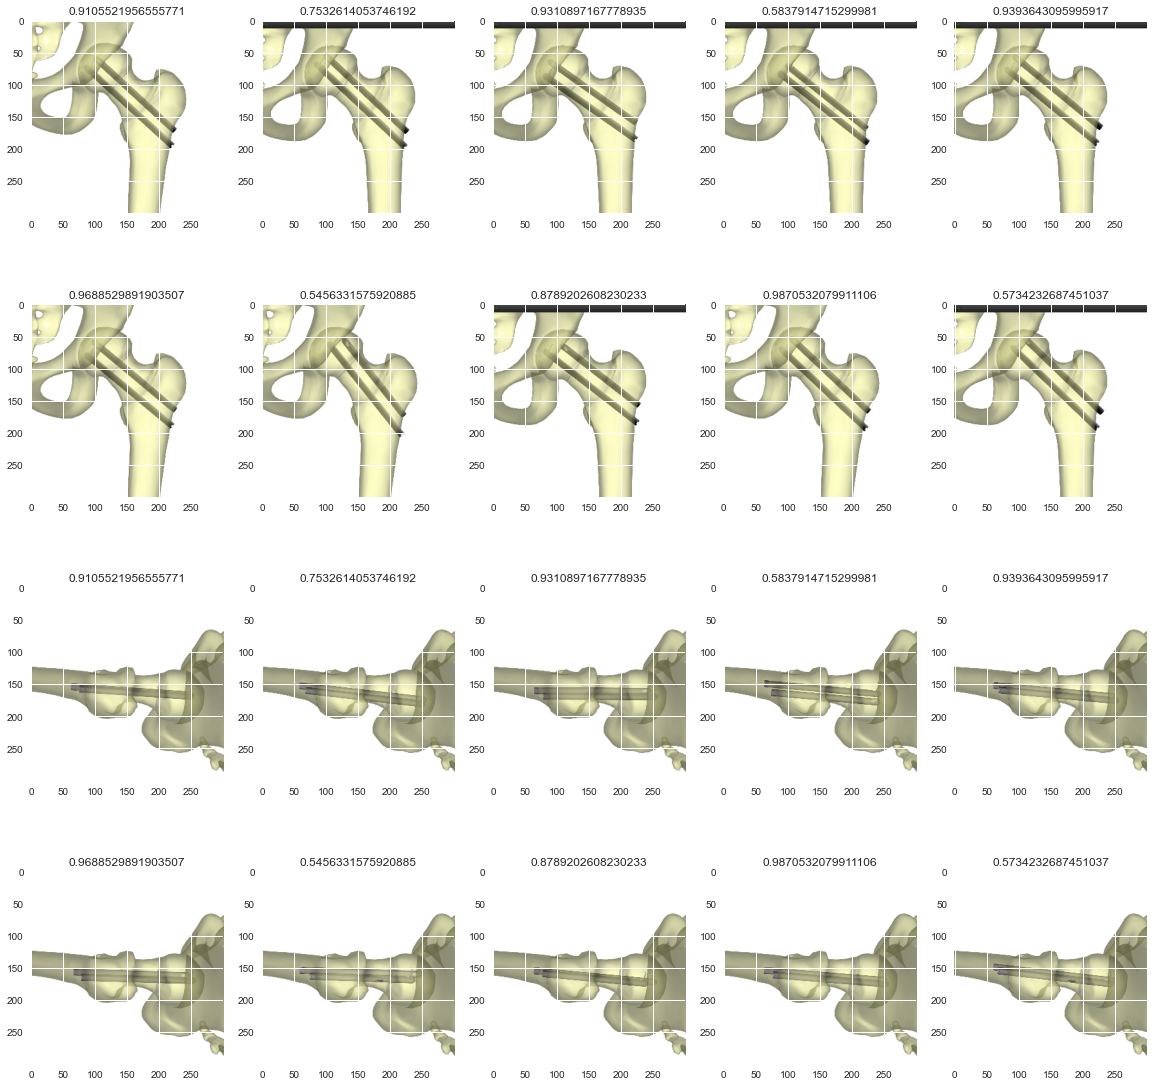

In [6]:
# show some of the first images
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,20))

num_images = 20

for i in range(int(num_images/2)):
    plt.subplot(4,5,i+1)
    plt.imshow(images[i].permute(1, 2, 3, 0)[0])
    plt.title((labels[i].item()*scaler.std)+scaler.mean) # convert back from scaled values

for i in range(int(num_images/2)):
    plt.subplot(4,5,int(num_images/2) + i+1)
    plt.imshow(images[i].permute(1, 2, 3, 0)[1])
    plt.title((labels[i].item()*scaler.std)+scaler.mean) # convert back from scaled values

In [7]:
# Define models
class Baseline(nn.Module):
    def __init__(self):
        super(Baseline, self).__init__()
        self.convolutional3d = nn.Sequential(
                  # CONV 3D_1
                  nn.Conv3d(in_channels=3, out_channels=8, kernel_size=3, stride = 1, padding= 1),
                  nn.ReLU(),

                  # CONV 3D_2
                  nn.Conv3d(in_channels=8, out_channels=16, kernel_size=2, stride = 1, padding= 0),
                  nn.ReLU(),
        )
        self.convolutional = nn.Sequential(
                  # CONV 1_1
                  nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
                  nn.ReLU(),

                  # CONV 1_2
                  nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
                  nn.MaxPool2d(kernel_size=2),
                  nn.ReLU(),

                  # CONV 2_1
                  nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
                  nn.ReLU(),

                  # CONV 2_2
                  nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
                  nn.ReLU(),
        )
        self.fully_connected = nn.Sequential(
                nn.Linear(64*64*64, 1),  
                )

    def forward(self, x):
      x = self.convolutional3d(x)
      x = torch.squeeze(x,dim = 2)
      x = self.convolutional(x)
      x = torch.flatten(x,1)
      x = self.fully_connected(x).squeeze()
      return x

# VGG16 takes an image of 224 x 224 with 3 channels as input
class VGG16(nn.Module):
  def __init__(self,):
    super(VGG16, self).__init__()

    self.convolutional3d_2_2d = nn.Sequential(
                  # CONV 3D_1
                  nn.Conv3d(in_channels=3, out_channels=8, kernel_size=3, stride = 1, padding= 1),
                  nn.ReLU(inplace=True),

                  # CONV 3D_2
                  nn.Conv3d(in_channels=8, out_channels=3, kernel_size=2, stride = 1, padding= 0),
                  nn.ReLU(inplace=True),
        )

    self.vgg16 = torchvision.models.vgg16(pretrained=True)

    #Freeze the parameters (by using this method, you can freeze the parameters in the convolutional layers and/or the fully connected layers)
    for param in self.vgg16.parameters(): # convolutional
      param.requires_grad = False

    #for param in self.vgg16.classifier.parameters(): # fully connected
    #  param.requires_grad = False

    #Modify the last layer
    n_features = self.vgg16.classifier[3].in_features #Number of features (inputs) in the last layer we want to keep
    features = list(self.vgg16.classifier.children())[:-4] # remove the last two FC layers
    features.extend([nn.Linear(n_features, 1)]) #1 output (numeric)
    self.vgg16.classifier = nn.Sequential(*features)
    
  def forward(self, x):
    x = self.convolutional3d_2_2d(x)
    x = self.vgg16(x.squeeze())
    return x.squeeze()

# Inception v-3 takes an image of 299 x 299 with 3 channels as input
class Inception_v3(nn.Module):
  def __init__(self,):
    super(Inception_v3, self).__init__()

    self.convolutional3d_2_2d = nn.Sequential(
                  # CONV 3D_1
                  nn.Conv3d(in_channels=3, out_channels=8, kernel_size=3, stride = 1, padding= 1),
                  nn.ReLU(inplace=True),

                  # CONV 3D_2
                  nn.Conv3d(in_channels=8, out_channels=3, kernel_size=2, stride = 1, padding= 0),
                  nn.ReLU(inplace=True),
        )

    self.inception = torchvision.models.inception_v3(pretrained=True)

    #Freeze the parameters
    for param in self.inception.parameters():
      param.require_grad = False

    #Remove the last layer
    n_features = self.inception.fc.in_features #Number of features (inputs) in the last layer
    self.inception.fc = nn.Linear(n_features,1)
    
  def forward(self, x):
    x = self.convolutional3d_2_2d(x)
    x = self.inception(x.squeeze())
    return x[0]

In [8]:
model = Inception_v3()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
decayRate = 0.96
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

In [9]:
def count_parameters(model): 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

25115164

In [10]:
# model = VGG16()
# model.to(device)
# num_epochs = 50
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
# decayRate = 0.96
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

num_epochs = 2

out_dict = train(model, optimizer, train_loader, val_loader, num_epochs=num_epochs, validation = True, scheduler=scheduler)
#out_dict = train(model, optimizer, num_epochs, validation= True, scheduler=scheduler) # scheduler = scheduler)

wandb.config = {
  "learning_rate": scheduler.get_last_lr()[0],
  "epochs": num_epochs,
  "batch_size": batch_size
}

  0%|          | 0/2 [00:00<?, ?epoch/s]

  0%|          | 0/93 [00:00<?, ?it/s]

tensor([[-0.0854],
        [ 0.3288],
        [-0.4471],
        [-0.2642],
        [-0.0906],
        [-0.2517],
        [-0.4010],
        [-0.0186],
        [-0.1201],
        [-0.1165],
        [ 0.0679],
        [ 0.0870]], grad_fn=<AddmmBackward0>)


/Users/ditteblom/OneDrive - Danmarks Tekniske Universitet/Arbejde/CAMES/Ort kir AI projekt/scripts/utils.py:36: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(output, target)


tensor([[ 0.1490],
        [ 0.5098],
        [-0.2967],
        [ 0.5295],
        [-0.1650],
        [-0.7257],
        [-0.3387],
        [ 0.2795],
        [-0.4466],
        [ 0.0786],
        [ 0.3362],
        [-0.3395]], grad_fn=<AddmmBackward0>)
tensor([[ 0.2934],
        [-0.0371],
        [ 0.3271],
        [ 0.2056],
        [ 0.4253],
        [ 0.1841],
        [ 0.3954],
        [-0.3106],
        [ 0.2840],
        [ 0.0924],
        [-0.1224],
        [ 0.1377]], grad_fn=<AddmmBackward0>)
tensor([[-0.1998],
        [-0.0603],
        [-0.3391],
        [ 0.0757],
        [-0.2577],
        [ 0.1157],
        [-0.0158],
        [ 0.2588],
        [ 0.3848],
        [-0.1607],
        [ 0.1129],
        [-0.1495]], grad_fn=<AddmmBackward0>)
tensor([[ 0.1253],
        [ 0.0854],
        [ 0.0681],
        [ 0.3412],
        [-0.3820],
        [ 0.1073],
        [ 0.1538],
        [-0.0335],
        [ 0.2396],
        [ 0.1505],
        [ 0.0235],
        [ 0.0943]], grad_f

In [49]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")


images, labels = next(iter(test_loader))
outputs = model(images)

plt.figure(figsize=(20,20))

num_images = 20

for i in range(int(num_images/2)):
    plt.subplot(4,5,i+1)
    plt.imshow(images[i].permute(1, 2, 3, 0)[0])
    plt.title(f'{(labels[i].item()*scaler.std)+scaler.mean:.3f}, {(outputs[i].item()*scaler.std)+scaler.mean:.3f}')

for i in range(int(num_images/2)):
    plt.subplot(4,5,int(num_images/2) + i+1)
    plt.imshow(images[i].permute(1, 2, 3, 0)[1])
    plt.title(f'{(labels[i].item()*scaler.std)+scaler.mean:.3f}, {(outputs[i].item()*scaler.std)+scaler.mean:.3f}')

Error in callback <function _WandbInit._resume_backend at 0x7fe0b44e2310> (for pre_run_cell):


Exception: The wandb backend process has shutdown

Feature batch shape: torch.Size([24, 3, 2, 225, 225])
Labels batch shape: torch.Size([24])


KeyboardInterrupt: 

Error in callback <function _WandbInit._pause_backend at 0x7fe0b44e24c0> (for post_run_cell):


Exception: The wandb backend process has shutdown

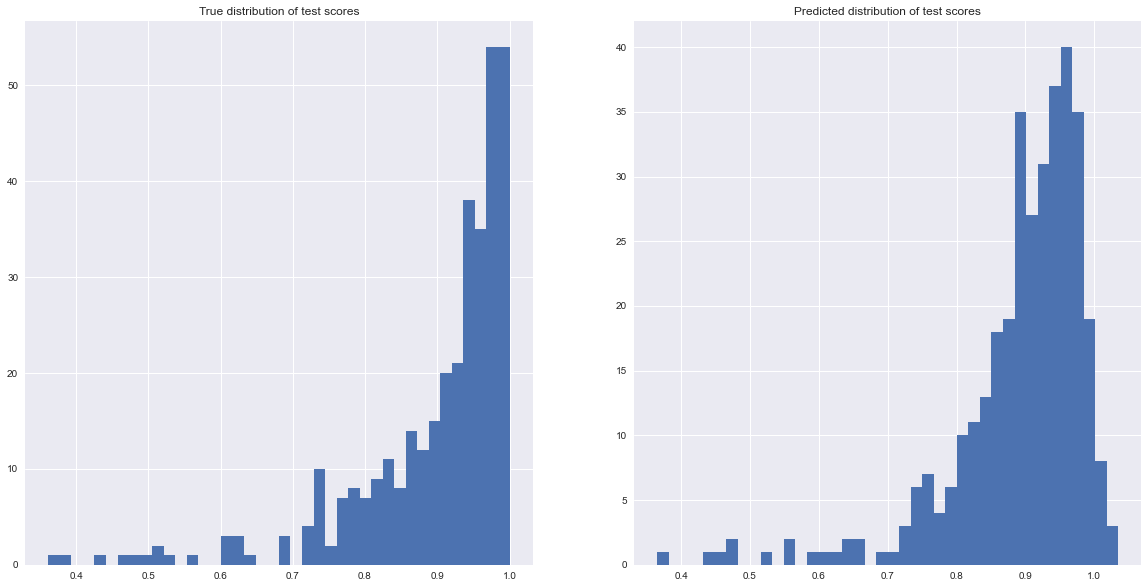

In [ ]:
plt.figure(figsize=(20,10))

test_scores = []
for i in range(testset.__len__()):
    _, tmp = testset.__getitem__(i)
    test_scores.append((tmp*scaler.std)+scaler.mean)

plt.subplot(1,2,1)
plt.title("True distribution of test scores")
plt.hist(test_scores, bins = 40)

test_predict = []
for minibatch_no, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            #Forward pass your image through the network
            output = model(data)
            for i in range(len(output)):
                test_predict.append((output[i].item()*scaler.std)+scaler.mean)


plt.subplot(1,2,2)
plt.title("Predicted distribution of test scores")
plt.hist(test_predict, bins = 40)

plt.show()

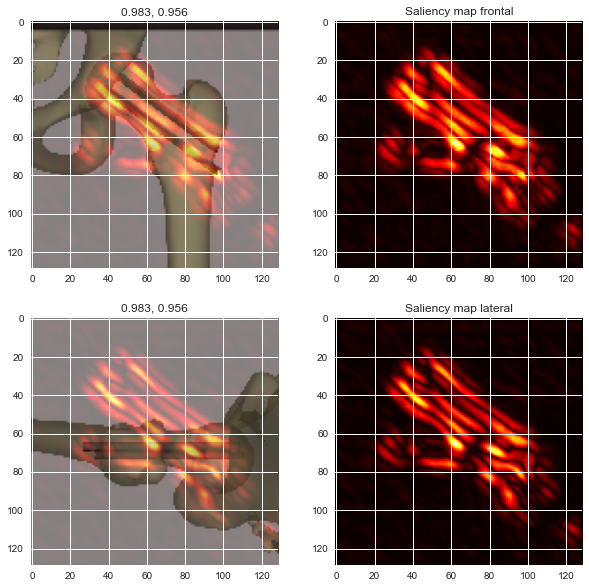

In [ ]:
idx = 10

images, _ = testset.__getitem__(idx)
_, model_slc = saliency(images, model)

plt.figure(figsize = (10,10))
plt.subplot(2,2,1)
plt.imshow(images.permute(1, 2, 3, 0)[0])
plt.title(f'{(labels[idx].item()*scaler.std)+scaler.mean:.3f}, {(outputs[idx].item()*scaler.std)+scaler.mean:.3f}')
plt.imshow(model_slc[0], cmap = plt.cm.hot, alpha = 0.5)
plt.subplot(2,2,2)
plt.title('Saliency map frontal')
plt.imshow(model_slc[0], cmap = plt.cm.hot)
plt.subplot(2,2,3)
plt.imshow(images.permute(1, 2, 3, 0)[1])
plt.title(f'{(labels[idx].item()*scaler.std)+scaler.mean:.3f}, {(outputs[idx].item()*scaler.std)+scaler.mean:.3f}')
plt.imshow(model_slc[1], cmap = plt.cm.hot, alpha = 0.5)
plt.subplot(2,2,4)
plt.title('Saliency map lateral')
plt.imshow(model_slc[1], cmap = plt.cm.hot)

plt.show()

